In [63]:
%matplotlib inline 
import Calculate_ABA_Flinkelsteinlab as ABA
reload(ABA)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

import seaborn as sns 
sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');

#import plotsettings 
#publishable = plotsettings.Set('Cell') 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

## Loading the data

In [64]:
#filename = 'cas9-target-d-replicate-1-delta-abas.txt'
filename = 'cas9-target-e-replicate-1-delta-abas.txt'
Path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
Cas='Cas9'


data = pd.read_table(Path+filename, skiprows=3)
on_target = (pd.read_table(Path+filename, skiprows=1, nrows=1).columns.values[0]).split(' ')[4]
data_name = pd.read_table(Path+filename, nrows=1).columns.values[0][2:]
data.rename(columns={'# Sequence': 'Sequence'}, inplace=True)

## Data processing

In [65]:
def separate_PAM(S, Cas='Cas9'):
    if Cas == 'Cas9':
        PAM_len =3
        PAM = S[-PAM_len:]
        s = S[0:-PAM_len]
    return PAM, s

def find_Mutations(S, T, Cas='Cas9'):
    PAM, s = separate_PAM(S, Cas)
    _, t = separate_PAM(T, Cas)
    canonical = False
    if PAM[1:]=='GG':
        canonical = True
    MM = SequenceMatcher(None, t, s).get_opcodes()
    for mm in MM:
        if mm[0]=='equal':
            MM.remove(mm)
    return [PAM, canonical, MM]

def get_Mut_type(Seq_Analysis):
    Muts = Seq_Analysis[2]
    Mut_type = list(set(map(lambda x:x[0], Muts)))
    return Mut_type

        
        
        

In [66]:
data['Seq_Analysis'] = data['Sequence'].apply(lambda x: find_Mutations(x, on_target, Cas))
data['PAM'] = data['Seq_Analysis'].apply(lambda x:x[0])
data['Length_diff'] = data['Sequence'].apply(lambda x: len(x)-len(on_target))
data['Canonical PAM'] = data['Seq_Analysis'].apply(lambda x:x[1])
data['Mutation_type'] = data['Seq_Analysis'].apply(get_Mut_type)
data['Mutation_type'] = data.apply(lambda x: '|'.join(map(lambda y:y[0], 
                                    x['Mutation_type'])) if x['Length_diff']!=0 else 'r', 
                                    axis=1)


In [67]:
def find_mismatches(x,on_target, Cas='Cas9'):
    '''
    This will generate the "Mutation ID" for the row x of the dataframe where there is no deletion/insertion.
    Input:
    x: a row of the data frame
    on_target: actual target
    Cas: Cas type
    '''
    
    _, s = separate_PAM(x['Sequence'], Cas)
    _, t = separate_PAM(on_target, Cas)
    positions = np.arange(0,len(t))
    MM_pos = list(positions[np.array(list(t))!=np.array(list(s))])
    MM_seq = list(np.array(list(s))[MM_pos])
    ID_list = []
    for n in range(0,len(MM_pos)):
        pos_seq = 'r' + ':' + str(MM_pos[n]) + ':' + MM_seq[n]
        ID_list.append(pos_seq) 
    return '|'.join(ID_list)

def analyse_mut(mut, s, t):
    
    '''
    This unpacks ONE 5-tuple of the kind which are in the "Seq_Analysis" column. 
    I use this function only when the mutations cannot described purely by replacement.
    Input:
    mut: 5-tuple resulted from SequenceMatcher(t, s).get_opcodes()
    s: mutated target (excluding PAM)
    t: perfect target (excluding PAM)
    Output:
    "Mutation ID" string
    '''
    
    mut_type = mut[0][0];
    if mut_type == 'r':
        mut_pos = range(mut[1],mut[2])
        if len(mut_pos) != len(range(mut[3],mut[4])):
            ID = 'ud'
            return ID
        s_list = np.array(list(s))
        mut_seq = list(s_list[mut_pos])
        ID_list = []
        for n in range(0,len(mut_pos)):
            pos_seq = mut_type + ':' + str(mut_pos[n]) + ':' + mut_seq[n]
            ID_list.append(pos_seq) 
        ID = '|'.join(ID_list)
        return ID
    if mut_type == 'i':
        mut_pos = range(mut[3],mut[4])
        s_list = np.array(list(s))
        mut_seq = list(s_list[mut_pos])
        ID = mut_type + ':' + str(mut[1]) + ':' + ''.join(mut_seq)
        return ID
    if mut_type == 'd':
        mut_pos = range(mut[1],mut[2])
        s_list = np.array(list(t))
        mut_seq = list(s_list[mut_pos])
        ID = mut_type + ':' + str(mut[1]) + ':' + ''.join(mut_seq)
        return ID

        
def build_Mut_ID(x,on_target, Cas='Cas9'):
    '''
    This will generate the "Mutation ID" for the row x of the dataframe.
    Input:
    x: a row of the data frame
    on_target: actual target
    Cas: Cas type
    '''
    
    if x['Length_diff'] == 0:
        return find_mismatches(x,on_target, Cas)
    _, s = separate_PAM(x['Sequence'], Cas)
    _, t = separate_PAM(on_target, Cas)
    Muts = x['Seq_Analysis'][2]
    ID_list = []
    for mut in Muts:
        ID = analyse_mut(mut, s, t)
        if ID == 'ud':
            return 'ud'
        ID_list.append(ID)
    return '|'.join(ID_list)

def find_mismatc_num(x,on_target, Cas='Cas9'):
    '''
    This will find the mismatch number for the row x of the dataframe where there is no deletion/insertion.
    Otherwie it gives nan.
    Input:
    x: a row of the data frame
    on_target: actual target
    Cas: Cas type
    '''
    if x['Length_diff'] != 0:
        return np.nan
    _, s = separate_PAM(x['Sequence'], Cas)
    _, t = separate_PAM(on_target, Cas)
    positions = np.arange(0,len(t))
    MM_num = int(np.sum(np.array(list(t))!=np.array(list(s))))
    return MM_num

In [68]:
data['Mut_ID'] = data.apply(lambda x: build_Mut_ID(x,on_target, Cas), axis=1)
data['MM_num'] = data.apply(lambda x: find_mismatc_num(x,on_target, Cas), axis=1)
data['on_target'] = data['Sequence'] == on_target
data = data[['Sequence','on_target','PAM','Canonical PAM','Length_diff','Mutation_type','Mut_ID','MM_num','Delta ABA (kBT)','Uncertainty']]

In [69]:
output_filename = filename.split('.')[0]+'-'+'processed'+'.csv'
data.to_csv(Path+output_filename, index=False)
data.head()

,Sequence,on_target,PAM,Canonical PAM,Length_diff,Mutation_type,Mut_ID,MM_num,Delta ABA (kBT),Uncertainty
0,TTTAGACCCATAAAGATAAGACGCTGG,False,TGG,True,0,r,r:7:C|r:17:A,2.0,2.127065,0.042464
1,TTTAGACGCTTAAAGATGAGAGGCTGG,False,TGG,True,0,r,r:9:T|r:21:G,2.0,2.611770,0.039588
2,TTTAGGAACGCATAAAGATGAGACGCTGG,False,TGG,True,2,i,i:5:GA,NaN,-0.325618,0.050050
3,TTTGACGCTAAAGATGAGACGCTGG,False,TGG,True,-2,d,d:3:A|d:9:A,NaN,0.250845,0.061186
4,TTTAGACGCATTAGGATGAGACGCTGG,False,TGG,True,0,r,r:11:T|r:13:G,2.0,1.330186,0.046995


## Single mismatches

In [70]:
single_MM_data = data[(data['MM_num']==1)&(data['Canonical PAM']==True)].copy()
single_MM_data = single_MM_data[['Mut_ID', 'Delta ABA (kBT)', 'Uncertainty']]
single_MM_data['MM_pos'] = single_MM_data['Mut_ID'].apply(lambda x: x.split(':')[1])
single_MM_data.head()

,Mut_ID,Delta ABA (kBT),Uncertainty,MM_pos
37,r:20:G,2.312526,0.035926,20
42,r:0:G,0.057772,0.028894,0
91,r:6:T,-0.254749,0.065941,6
104,r:16:G,1.320001,0.065184,16
114,r:17:A,0.810755,0.056585,17


In [71]:
mean_single_MM_data = single_MM_data[['MM_pos','Delta ABA (kBT)','Uncertainty']].groupby('MM_pos').mean().reset_index()
mean_single_MM_data['MM_pos'] = mean_single_MM_data['MM_pos'].astype(int)
mean_single_MM_data.sort_values('MM_pos',inplace=True,ascending=False)
mean_single_MM_data.sort_values('Delta ABA (kBT)').head()


,MM_pos,Delta ABA (kBT),Uncertainty
20,6,-0.155049,0.063433
19,5,-0.120843,0.070773
18,4,-0.112212,0.066128
21,7,-0.096608,0.067254
17,3,-0.037757,0.079326


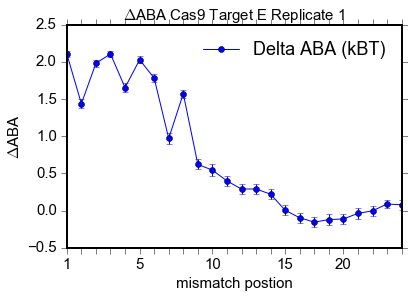

In [98]:
mean_single_MM_data.plot(x='MM_pos', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
plt.xticks([i for i in range(24)], 
           ['','','','',20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);
plt.xlabel('mismatch postion', fontsize=15)
plt.ylabel('$\Delta$ABA', fontsize=15)
plt.title('$\Delta$ABA '+data_name,fontsize=15)

## Double mismatches

In [73]:
double_MM_data = data[(data['Canonical PAM'] == True) & (data['MM_num'] == 2)].copy()
double_MM_data = double_MM_data[['Mut_ID', 'Delta ABA (kBT)', 'Uncertainty']]
double_MM_data['MM_pos'] = double_MM_data['Mut_ID'].apply(lambda x: ':'.join(map(lambda y: y.split(':')[1],x.split('|'))))
double_MM_data.head()

,Mut_ID,Delta ABA (kBT),Uncertainty,MM_pos
0,r:7:C|r:17:A,2.127065,0.042464,7:17
1,r:9:T|r:21:G,2.611770,0.039588,9:21
4,r:11:T|r:13:G,1.330186,0.046995,11:13
10,r:5:G|r:18:G,1.706772,0.044205,5:18
15,r:14:C|r:19:C,2.612995,0.048553,14:19


In [74]:
mean_double_MM_data = double_MM_data[['MM_pos','Delta ABA (kBT)','Uncertainty']].groupby('MM_pos').mean().reset_index()
mean_double_MM_data.sort_values('Delta ABA (kBT)').head()

,MM_pos,Delta ABA (kBT),Uncertainty
191,4:5,-0.164717,0.066408
192,4:6,-0.135857,0.063174
171,3:4,-0.125972,0.075163
173,3:6,-0.109376,0.065312
151,2:4,-0.108586,0.068470


In [75]:
PAM_len = len(data['PAM'].iloc[0])
L = len(on_target)-PAM_len
double_MM_map = np.empty((L,L))
double_MM_map[:] = np.nan
for i in range(0,L):
    for j in range(i,L):
        if j>i:
            ID = str(i) + ':' + str(j)
            double_MM_map[i,j] = mean_double_MM_data[mean_double_MM_data['MM_pos']==ID]['Delta ABA (kBT)']
            double_MM_map[j,i] = mean_double_MM_data[mean_double_MM_data['MM_pos']==ID]['Delta ABA (kBT)']
        else:
            double_MM_map[i,i] = mean_single_MM_data[mean_single_MM_data['MM_pos']==i]['Delta ABA (kBT)']

### The tiles on the diagonal correspond to single mismatches.

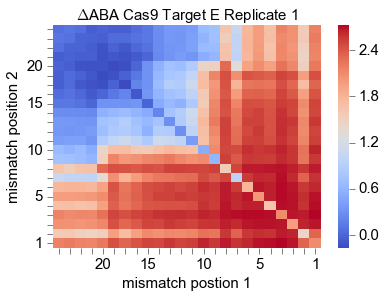

In [76]:
sns.heatmap(double_MM_map, cmap='coolwarm',cbar=True)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
plt.xticks([i+0.5 for i in range(24)], 
           ['','','','',20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);
plt.yticks([i+0.5 for i in range(24)], 
           ['','','','',20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);
plt.xlabel('mismatch postion 1', fontsize=15)
plt.ylabel('mismatch position 2', fontsize=15)
plt.title('$\Delta$ABA '+data_name,fontsize=15)

## Blocks of mismatches

In [87]:
def make_block_ID(x):
    MM_pos_array = np.array(map(int, map(lambda y: y.split(':')[1], x.split('|'))))
    bi = MM_pos_array[-1]
    bf = MM_pos_array[0]
    if len(MM_pos_array)!=len(np.arange(bf,bi+1)):
        return 'no block'
    if np.any(MM_pos_array == np.arange(bf,bi+1)):
        block_ID = str(bi) + ':' + str(bf)
    else:
        block_ID = 'no block'
    return(block_ID)

In [88]:
multi_MM_data = data[(data['Canonical PAM'] == True) & (data['MM_num'] > 2)].copy()
multi_MM_data = multi_MM_data[['Mut_ID', 'Delta ABA (kBT)', 'Uncertainty', 'MM_num']]
multi_MM_data['MM_num'] = multi_MM_data['MM_num'].astype(int)
multi_MM_data['Block_ID'] = multi_MM_data['Mut_ID'].apply(make_block_ID)
multi_MM_data = multi_MM_data[multi_MM_data['Block_ID']!='no block']
multi_MM_data.drop('Mut_ID', inplace=True, axis=1)
multi_MM_data = multi_MM_data[['Block_ID', 'MM_num', 'Delta ABA (kBT)', 'Uncertainty']]
multi_MM_data.sort_values(['MM_num', 'Block_ID']).head()

,Block_ID,MM_num,Delta ABA (kBT),Uncertainty
2893,10:8,3,0.575117,0.049060
3556,11:9,3,0.170064,0.062187
6252,12:10,3,0.868284,0.052884
2596,13:11,3,1.740295,0.054038
4276,14:12,3,2.350633,0.042771


In [89]:
mean_multi_MM_data = multi_MM_data.groupby('Block_ID').mean().reset_index()
mean_multi_MM_data.sort_values('Delta ABA (kBT)').head()

,Block_ID,MM_num,Delta ABA (kBT),Uncertainty
226,5:3,3,-0.195531,0.074529
230,6:3,4,-0.131571,0.069257
220,4:0,5,-0.131412,0.073096
231,6:4,3,-0.126871,0.071953
217,2:0,3,-0.121044,0.074571


In [90]:
block_MM_map = np.empty((L,L))
block_MM_map[:] = np.nan
ID_list = list(multi_MM_data['Block_ID'])
for i in range(0,L):
    for j in range(0,i):
        ID = str(i) + ':' + str(j)
        if ID in ID_list:
            block_MM_map[i,j] = mean_multi_MM_data[mean_multi_MM_data['Block_ID']==ID]['Delta ABA (kBT)']
            

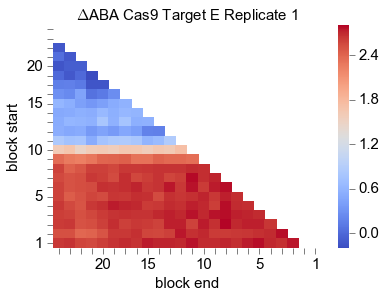

In [95]:
sns.heatmap(block_MM_map, cmap='coolwarm',cbar=True)
plt.xticks([i+0.5 for i in range(24)], 
          ['','','','',20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);
plt.yticks([i+0.5 for i in range(24)], 
           ['','','','',20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);
plt.xlabel('block end', fontsize=15)
plt.ylabel('block start', fontsize=15)
plt.title('$\Delta$ABA '+data_name,fontsize=15)

In [82]:
Boyle_seq = 'GACGCATAAAGATGAGACGCTGG'
SequenceMatcher(None, on_target, Boyle_seq).get_opcodes()

[('delete', 0, 4, 0, 0), ('equal', 4, 27, 0, 23)]